## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0723 19:47:25.729440  5748 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 19:47:25.730442  5748 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 19:47:25.755442  5748 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 19:47:25.756443  5748 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 19:47:25.759447  5748 depr

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0723 19:47:25.950458  5748 deprecation.py:323] From C:\Users\Ychu\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 170us/step - loss: 15.1036 - acc: 0.2704 - val_loss: 13.9632 - val_acc: 0.3311
Epoch 2/50
50000/50000 [==============================] - 8s 161us/step - loss: 13.0294 - acc: 0.3542 - val_loss: 12.1337 - val_acc: 0.3741
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 11.3547 - acc: 0.3802 - val_loss: 10.6024 - val_acc: 0.3826
Epoch 4/50
50000/50000 [==============================] - 8s 158us/step - loss: 9.9420 - acc: 0.3936 - val_loss: 9.3038 - val_acc: 0.4000
Epoch 5/50
50000/50000 [==============================] - 8s 167us/step - loss: 8.7410 - acc: 0.4043 - val_loss: 8.1969 - val_acc: 0.4092
Epoch 6/50
50000/50000 [==============================] - 9s 173us/step - loss: 7.7176 - acc: 0.4123 - val_loss: 7.2556 - val_acc: 0.4113
Epoch 7/50
50000/50000 [==============================] - 8s 159us/step - loss: 6.8446 - acc: 0.4189 - val_loss: 6.4

Epoch 2/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.9223 - acc: 0.3730 - val_loss: 1.8790 - val_acc: 0.3890
Epoch 3/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.8427 - acc: 0.4033 - val_loss: 1.8116 - val_acc: 0.4165
Epoch 4/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.7860 - acc: 0.4208 - val_loss: 1.7629 - val_acc: 0.4285
Epoch 5/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.7382 - acc: 0.4394 - val_loss: 1.7572 - val_acc: 0.4299
Epoch 6/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.6997 - acc: 0.4535 - val_loss: 1.7041 - val_acc: 0.4459
Epoch 7/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.6684 - acc: 0.4639 - val_loss: 1.6756 - val_acc: 0.4606
Epoch 8/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.6401 - acc: 0.4700 - val_loss: 1.6693 - val_acc: 0.4630
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 8s 160us/step - loss: 1.7131 - acc: 0.4009 - val_loss: 1.6817 - val_acc: 0.4102
Epoch 4/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.6563 - acc: 0.4219 - val_loss: 1.6317 - val_acc: 0.4314
Epoch 5/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.6079 - acc: 0.4364 - val_loss: 1.5963 - val_acc: 0.4391
Epoch 6/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.5685 - acc: 0.4511 - val_loss: 1.5736 - val_acc: 0.4452
Epoch 7/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.5363 - acc: 0.4622 - val_loss: 1.5548 - val_acc: 0.4575
Epoch 8/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5076 - acc: 0.4719 - val_loss: 1.5209 - val_acc: 0.4616
Epoch 9/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4779 - acc: 0.4826 - val_loss: 1.5045 - val_acc: 0.4651
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 8s 158us/step - loss: 1.6677 - acc: 0.4176 - val_loss: 1.6509 - val_acc: 0.4103
Epoch 5/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.6201 - acc: 0.4343 - val_loss: 1.6086 - val_acc: 0.4318
Epoch 6/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5796 - acc: 0.4491 - val_loss: 1.5721 - val_acc: 0.4454
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5455 - acc: 0.4587 - val_loss: 1.5500 - val_acc: 0.4498
Epoch 8/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.5146 - acc: 0.4687 - val_loss: 1.5269 - val_acc: 0.4609
Epoch 9/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.4855 - acc: 0.4802 - val_loss: 1.5070 - val_acc: 0.4700
Epoch 10/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4601 - acc: 0.4914 - val_loss: 1.5025 - val_acc: 0.4700
Epoch 11/50
50000/50000 [===================

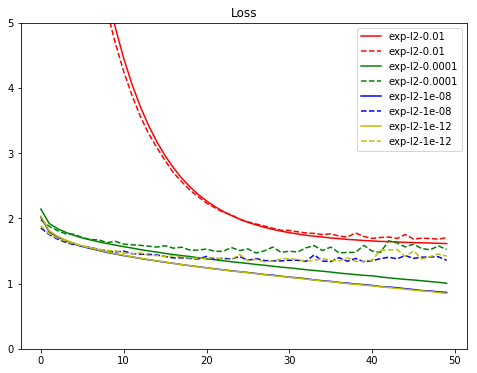

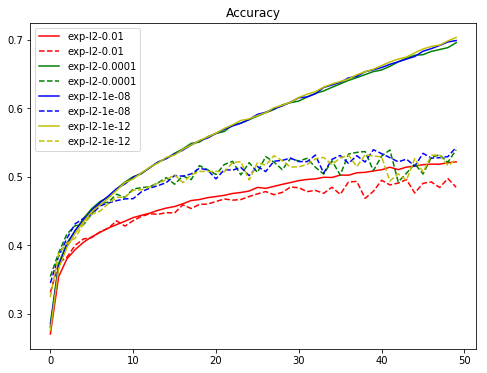

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果